In [1]:
!nvidia-smi

Thu Nov 16 07:56:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:37:00.0 Off |                    0 |
| N/A   61C    P0              43W / 250W |    903MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import shutil
from albumentations.pytorch import ToTensorV2
import albumentations as A
from glob import glob
import pandas as pd
import os
import cv2
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from ast import literal_eval
import random
from datetime import datetime
import matplotlib.pyplot as plt
import justshowit
import warnings

import numpy as np
from tqdm.notebook import tqdm
import wandb
from collections import defaultdict

#import clip
from PIL import Image

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
torch.autograd.set_detect_anomaly(True)

import seaborn
from transformers import logging
seaborn.set_style("whitegrid")
logging.set_verbosity_error()
eps = 1e-8 # an arbitrary small value to be used for numerical stability tricks

In [3]:
class Config:
    # Control
    debug = False
    wandb = True if (not debug) else False
    device = "cuda"
    folds = 4 if (not debug) else 2
    valid_update_frequency = 2
    run_script_path = "merged.ipynb"

    # Data
    epochs = 25 if (not debug) else 4
    batch_size = 32 if (not debug) else 16
    dl_workers = 0
    test_prop = 0.1
    max_len = 512

    # Model
    encoding_dim = 256
    init_temp = 0.07
    clip_max_temp = 100
    freeze_temp = False
    
    # Training
    lr = 5e-5
    modality = 'text_concat'
    assert modality in ["instructions", "ingredients", "text_concat"]

    # Loss
    triplet_margin = 1.
    loss_type = "contrastive"  # or "triplet"
    assert loss_type in ["contrastive", "triplet"]

    # Seed everything
    seed = 12
    torch.backends.cudnn.deterministic = False # 100% deterministic if true, but hella slow
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


cfg = Config()
if cfg.wandb:
    wandb.login(key="5f35577dd337c909579d63ec11b3184d93aeedd7")
    wandb.init(config=cfg, project="Merged", entity="advanced_dl_in_cv")
    wandb.run.name = "HPC - Poster results 002 - text_concat + contrastive"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: advanced_dl_in_cv (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/72/2/126104/.netrc


### Data:

#### Load and clean dataset:

In [4]:
df = pd.read_csv("../Data/Jakob/info.csv")
df = df.drop(columns=["Unnamed: 0", "Ingredients"])

# Lower case column names and all entries
df = df.rename(columns={c: c.lower() for c in df.columns})
for column in df:
    df[column] = df[column].str.lower()

# 30 entries have no image and will be removed
assert sum(df["image_name"] == "#name?") == 30
df = df[df["image_name"] != "#name?"]
assert df.shape == (13471, 4)

# 10 of the images are corrupted
corrupted_image_names = [
    "sesame-scallion-chicken-salad",
    "dakgangjeong-korean-sweet-crunchy-fried-chicken-maangchi",
    "crispy-turmeric-and-pepper-baked-chicken-wings",
    "salsa-de-arbol",
    "fancy-cranberry-sauce",
    "glazed-leeks-with-pine-nut-salsa-verde",
    "broccolini-with-sesame-sauce-and-lemon",
    "citrus-jerk-bass-fish-with-fonio",
    "creamsicle-macaroons",
    "pan-seared-salmon-on-baby-arugula-242445"
]
for name in corrupted_image_names:
    condition = df["image_name"] == name
    assert sum(condition) == 1
    df = df[~condition]
assert df.shape == (13461, 4)

# We have 5 title NANs
cond = df["title"].isna()
assert sum(df["title"].isna()) == 5
df = df[~cond]
assert df.shape == (13456, 4)

# We have 3 instruction NANs
cond = df["instructions"].isna()
assert sum(df["instructions"].isna()) == 3
df = df[~cond]
assert df.shape == (13453, 4)

# cleaned_ingredients is given in [line_1, line_2, ..., line_n]. This will be concatenated with a `|` in between
df["cleaned_ingredients"] = df["cleaned_ingredients"].apply(lambda text: "|".join(literal_eval(text)))

df = df.reset_index(drop=True)
df

title  \
0      miso-butter roast chicken with acorn squash pa...   
1                        crispy salt and pepper potatoes   
2                            thanksgiving mac and cheese   
3                     italian sausage and bread stuffing   
4                                           newton's law   
...                                                  ...   
13448                               brownie pudding cake   
13449  israeli couscous with roasted butternut squash...   
13450  rice with soy-glazed bonito flakes and sesame ...   
13451                                        spanakopita   
13452  mexican poblano, spinach, and black bean "lasa...   

                                            instructions  \
0      pat chicken dry with paper towels, season all ...   
1      preheat oven to 400°f and line a rimmed baking...   
2      place a rack in middle of oven; preheat to 400...   
3      preheat oven to 350°f with rack in middle. gen...   
4      stir together brown sugar and hot water in a c...   
...                                                  ...   
13448  preheat the oven to 350°f. into a bowl sift to...   
13449  preheat oven to 475°f.\nhalve lemons and scoop...   
13450  if using katsuo bushi flakes from package, moi...   
13451  melt 1 tablespoon butter in a 12-inch heavy sk...   
13452  lay 4 chiles on their sides on racks of gas bu...   

                                              image_name  \
0      miso-butter-roast-chicken-acorn-squash-panzanella   
1             crispy-salt-and-pepper-potatoes-dan-kluger   
2             thanksgiving-mac-and-cheese-erick-williams   
3              italian-sausage-and-bread-stuffing-240559   
4                     newtons-law-apple-bourbon-cocktail   
...                                                  ...   
13448                         brownie-pudding-cake-14408   
13449  israeli-couscous-with-roasted-butternut-squash...   
13450  rice-with-soy-glazed-bonito-flakes-and-sesame-...   
13451                                 spanakopita-107344   
13452  mexican-poblano-spinach-and-black-bean-lasagne...   

                                     cleaned_ingredients  
0      1 (3½–4-lb.) whole chicken|2¾ tsp. kosher salt...  
1      2 large egg whites|1 pound new potatoes (about...  
2      1 cup evaporated milk|1 cup whole milk|1 tsp. ...  
3      1 (¾- to 1-pound) round italian loaf, cut into...  
4      1 teaspoon dark brown sugar|1 teaspoon hot wat...  
...                                                  ...  
13448  1 cup all-purpose flour|2/3 cup unsweetened co...  
13449  1 preserved lemon|1 1/2 pound butternut squash...  
13450  leftover katsuo bushi (dried bonito flakes) fr...  
13451  1 stick (1/2 cup) plus 1 tablespoon unsalted b...  
13452  12 medium to large fresh poblano chiles (2 1/4...  

[13453 rows x 4 columns]

#### Train, validation and test

In [5]:
# Random folds/test split
fold_indexes, test_indexes = train_test_split(df.index, test_size=cfg.test_prop, shuffle=True)
assert round(len(fold_indexes) / len(df), 1) == (1 - cfg.test_prop), "train proportion is off"
assert round(len(test_indexes) / len(df), 1) == cfg.test_prop, "test proportion is off"
df["fold"] = pd.NA
df["is_test_data"] = False

# Define test rows
df.loc[test_indexes, "is_test_data"] = True
assert not df[df["is_test_data"]].index.isin(fold_indexes).any(), "test leakage"

# Define folds
iterator = np.array_split(fold_indexes, cfg.folds)
for i, valid_fold_index in enumerate(iterator):
    assert not pd.Series(test_indexes).isin(valid_fold_index).any(), "test leakage"
    df.loc[valid_fold_index, 'fold'] = i

# Final checks
for fold in range(cfg.folds):
    fold_is_defined = ~df["fold"].isna()
    df_fold = df[fold_is_defined & (df["fold"] == fold)]
    df_off_fold = df[fold_is_defined & (df["fold"] != fold)]
    assert not df_fold.index.isin(df_off_fold.index).any(), "validation leakage"
    assert not df_off_fold.index.isin(test_indexes).any(), "train to test leakage"
    assert not df_fold.index.isin(test_indexes).any(), "validation to test leakage"

assert (df[df["is_test_data"]].index == df[df["fold"].isna()].index).all(), "Something went wrong"
assert (df[~df["is_test_data"]].index == df[~df["fold"].isna()].index).all(), "Something went wrong"

#### Add relative path of images to dataframe:

In [6]:
image_paths = glob("../Data/Jakob/images/*")
image_paths = [p.replace("\\", "/") for p in image_paths]
assert all([p.endswith(".jpg") for p in image_paths])
df["image_path_relative"] = df["image_name"].apply(lambda p: f"../Data/Jakob/images/{p}.jpg")
assert df["image_path_relative"].apply(lambda p: os.path.exists(p)).all()

#### Truncate ingredients list to fit BERT token limit:

In [7]:
class Tokenizer:
    def __init__(self, bert_model:str='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)

    def __call__(self, text:str, truncate:bool=True):
        assert isinstance(text, str)
        text_tokenized = self.tokenizer.encode_plus(
            text,
            padding="max_length",
            truncation = truncate,
            add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
            max_length = cfg.max_len,      # Pad/truncate text to fit
            return_attention_mask = True,  # Make attention masks.
            return_tensors = 'pt',         # Pytorch tensors format.
        )
        return text_tokenized

In [8]:
# VISUALIZATION FOR POSTER. Is kinda slow to run every time
# tokenizer = Tokenizer()
# df["cleaned_ingredients_num_tokens"] =  [tokenizer(text, False)["attention_mask"].sum().item() for text in df["cleaned_ingredients"]]
# df["instructions_num_tokens"] = [tokenizer(text, False)["attention_mask"].sum().item() for text in df["instructions"]]
#
# fig, ax = plt.subplots(figsize=(15,5))
# df["cleaned_ingredients_num_tokens"].plot.hist(bins=30, ax=ax, title="Ingredients")
# max_bar_height = max([n.get_height() for n in ax.patches])
# ax.plot([512, 512], [0, max_bar_height], "--", linewidth=4)
# stats = f"{(df['cleaned_ingredients_num_tokens'] > 512).sum()} "
# stats += f"({(df['cleaned_ingredients_num_tokens'] > 512).mean()*100 :.3}%)"
# print(f"Rows that will be affected by the truncation: ", stats)
#
# fig, ax = plt.subplots(figsize=(15,5))
# df["instructions_num_tokens"].plot.hist(bins=30, ax=ax, title="Instructions")
# max_bar_height = max([n.get_height() for n in ax.patches])
# ax.plot([512, 512], [0, max_bar_height], "--", linewidth=4)
# stats = f"{(df['instructions_num_tokens'] > 512).sum()} "
# stats += f"({(df['instructions_num_tokens'] > 512).mean()*100 :.3}%)"
# print(f"Rows that will be affected by the truncation: ", stats)

#### Dataset:

In [9]:
class Dataset:
    def __init__(self, df:pd.DataFrame, test:bool=False, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), h=224, w=224):
        # Setup
        self.df = df
        self.tokenizer = Tokenizer()

        # Load everything into RAM
        self.original_df_indexes = torch.tensor([i for i in df.index])
        self.images = [cv2.imread(path)[:, :, ::-1] for path in df["image_path_relative"]]
        self.text_concat = [self.tokenizer(f"{t1} [SEP] {t2}") for (t1, t2) in zip(df["instructions"], df["cleaned_ingredients"])]
        self.instructions = [self.tokenizer(text) for text in df["instructions"]]
        self.ingredients = [self.tokenizer(text) for text in df["cleaned_ingredients"]]

        # Checks
        assert len(self.images) == len(self.text_concat) == len(self.instructions) == len(self.ingredients)
        assert max([len(t["input_ids"].squeeze()) for t in self.text_concat]) <= 512
        assert max([len(t["input_ids"].squeeze()) for t in self.ingredients]) <= 512
        assert max([len(t["input_ids"].squeeze()) for t in self.instructions]) <= 512

        # Augmentation
        if test:
            self.augmentation = A.Compose([
                A.Resize(h, w, p=1.0),
                A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                A.pytorch.ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.RandomResizedCrop(224, 224, p=1.0),
                A.RandomRotate90(),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
                A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
                A.MultiplicativeNoise(multiplier=[0.8, 1.2], elementwise=True, p=0.5),
                A.MotionBlur(),
                A.ShiftScaleRotate(p=0.5),
                A.CoarseDropout(max_holes=15, max_height=15, max_width=15, p=0.5),
                A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                A.pytorch.ToTensorV2()
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i:int):
        index = self.original_df_indexes[i]
        image_raw = self.images[i]
        image_augmented = self.augmentation(image=image_raw)["image"]
        text_concat_tokenizer_out = self.text_concat[i]
        instructions_tokenizer_out = self.instructions[i]
        ingredients_tokenizer_out = self.ingredients[i]
        return index, image_augmented, instructions_tokenizer_out, ingredients_tokenizer_out, text_concat_tokenizer_out


In [10]:
# The output of the BERT tokenizer has varying shapes, so we need to stitch the batch together manually
def collate_fn(batch):
    # Unpack from dataset
    batch_original_indexes = []
    batch_images = []
    batch_concat = []
    batch_instructions = []
    batch_ingredients = []
    for index, (original_index, image, instructions, ingredients, concatenated) in enumerate(batch):
        batch_original_indexes.append(original_index)
        batch_images.append(image)
        batch_concat.append(concatenated)
        batch_instructions.append(instructions)
        batch_ingredients.append(ingredients)

    # Stack everything into torch tensors that can be used by our ResNet and BERT-model
    batch_images = torch.stack(batch_images).to(cfg.device)
    batch_original_indexes = torch.tensor(batch_original_indexes).to(cfg.device)

    batch_concat = {
        'input_ids': torch.stack([item['input_ids'] for item in batch_concat]).to(cfg.device).squeeze(1),
        'token_type_ids': torch.stack([item['token_type_ids'] for item in batch_concat]).to(cfg.device).squeeze(1),
        'attention_mask' : torch.stack([item['attention_mask'] for item in batch_concat]).to(cfg.device).squeeze(1),
    }

    batch_instructions = {
        'input_ids': torch.stack([item['input_ids'] for item in batch_instructions]).to(cfg.device).squeeze(1),
        'token_type_ids': torch.stack([item['token_type_ids'] for item in batch_instructions]).to(cfg.device).squeeze(1),
        'attention_mask' : torch.stack([item['attention_mask'] for item in batch_instructions]).to(cfg.device).squeeze(1),
    }

    batch_ingredients = {
        'input_ids': torch.stack([item['input_ids'] for item in batch_ingredients]).to(cfg.device).squeeze(1),
        'token_type_ids': torch.stack([item['token_type_ids'] for item in batch_ingredients]).to(cfg.device).squeeze(1),
        'attention_mask' : torch.stack([item['attention_mask'] for item in batch_ingredients]).to(cfg.device).squeeze(1),
    }

    return batch_images, batch_original_indexes, batch_instructions, batch_ingredients, batch_concat

#### Build data loaders function:

In [11]:
def load_data(fold:int, for_visualization:bool=False):
    assert fold < cfg.folds

    # Splits
    test_index =  df[df["is_test_data"]].index
    train_index = df[fold_is_defined & (df["fold"] != fold)].index
    valid_index = df[fold_is_defined & (df["fold"] == fold)].index
    assert not (test_index.isin(train_index).any() or test_index.isin(valid_index).any()), "test leakage"
    assert not (train_index.isin(valid_index).any() or valid_index.isin(train_index).any()), "validation leakage"

    if for_visualization:
        train_index = train_index[:5]
        valid_index = valid_index[:5]
        test_index = test_index[:5]
    elif cfg.debug:
        train_index = train_index[:40]
        valid_index = valid_index[:20]
        test_index = test_index[:20]

    assert not any(v_i in train_index for v_i in valid_index)
    assert not any(t_i in valid_index for t_i in train_index)
    train_df = df.iloc[train_index]
    valid_df = df.iloc[valid_index]
    test_df = df.iloc[test_index]

    # Dataset and DataLoader
    train_dataset = Dataset(train_df, test=False)
    valid_dataset  = Dataset(valid_df, test=True)
    test_dataset  = Dataset(test_df, test=True)

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=cfg.dl_workers, collate_fn=collate_fn, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=cfg.batch_size, num_workers=cfg.dl_workers, collate_fn=collate_fn, shuffle=False)
    test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=cfg.batch_size, num_workers=cfg.dl_workers, collate_fn=collate_fn, shuffle=False)
    
    return train_dl, valid_dl, test_dl

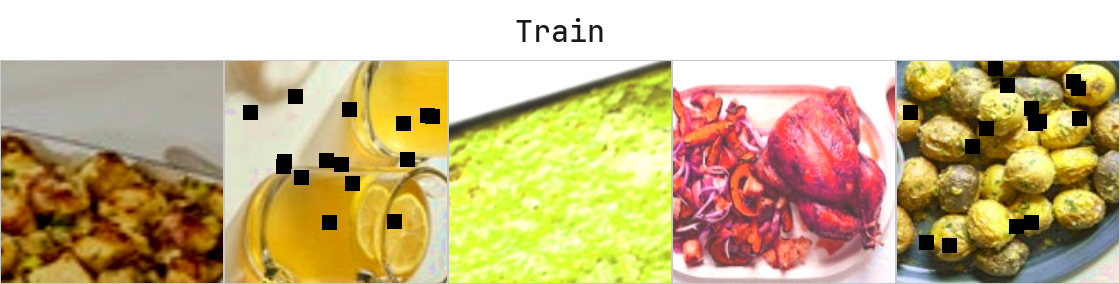

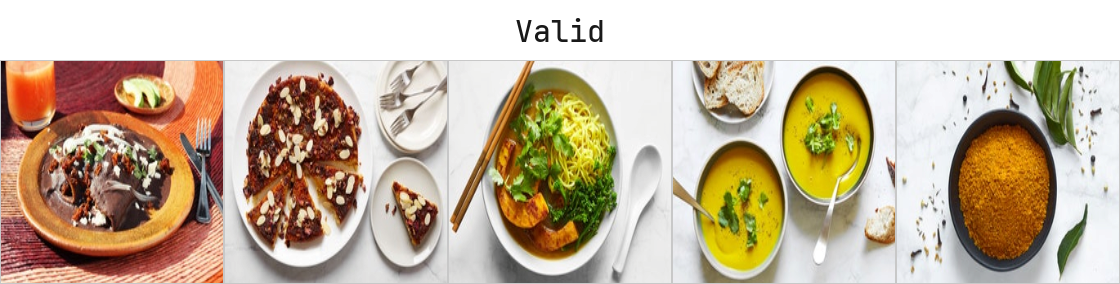

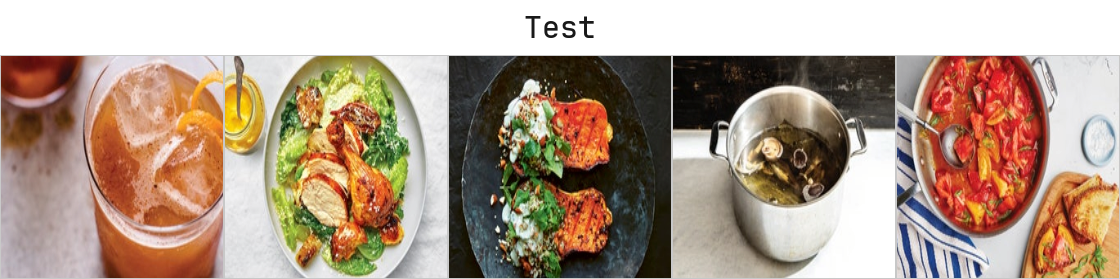

In [12]:
# Sanity check
def sanity_check():
    train_dl, valid_dl, test_dl = load_data(fold=np.random.randint(0, cfg.folds), for_visualization=True)
    for title, dl in [("Train", train_dl), ("Valid", valid_dl), ("Test", test_dl)]:
        batch = next(iter(dl))
        assert len(batch) == 5
        batch_images, batch_original_indexes, batch_instructions, batch_ingredients, batch_concat = batch
        assert len(batch_images) == len(batch_instructions["input_ids"])      == len(batch_concat["input_ids"])      == len(batch_ingredients["input_ids"])      == len(batch_original_indexes)
        assert len(batch_images) == len(batch_instructions["token_type_ids"]) == len(batch_concat["token_type_ids"]) == len(batch_ingredients["token_type_ids"]) == len(batch_original_indexes)
        assert len(batch_images) == len(batch_instructions["attention_mask"]) == len(batch_concat["attention_mask"]) == len(batch_ingredients["attention_mask"]) == len(batch_original_indexes)
        try:
            justshowit.show(batch_images, title=title)
        except:
            pass
sanity_check()

### Loss functions:

In [13]:
def get_acc_metrics(logits:torch.Tensor) -> dict:
    with torch.no_grad():
        probs_vertical = logits.softmax(1) # TODO: I'm afraid these are flipped the wrong way
        probs_horizontal = logits.softmax(0)

        # Vertically
        i2t_acc1 = []
        i2t_acc5 = []
        for i, row in enumerate(probs_vertical):
            assert (row.sum() - 1).abs() < 1e-5, f"Softmax is incorrect vertically, should add to 1 --> {row=}"
            _ , indexes = row.sort(descending=True)
            indexes = indexes.detach().cpu().numpy()
            i2t_acc1.append(i == indexes[0])
            i2t_acc5.append((i in indexes[:5]))
        assert all([acc1 <= acc5 for (acc1, acc5) in zip(i2t_acc1, i2t_acc5)]), "acc1 > acc5"

        # Horizontally
        t2i_acc1 = []
        t2i_acc5 = []
        for i, col in enumerate(probs_horizontal.T):
            assert (col.sum() - 1).abs() < 1e-5, f"Softmax is incorrect horizontally, should add to 1 --> {col=}"
            _ , indexes = col.sort(descending=True)
            indexes = indexes.detach().cpu().numpy()
            t2i_acc1.append(i == indexes[0])
            t2i_acc5.append((i in indexes[:5]))
        assert all([acc1 <= acc5 for (acc1, acc5) in zip(t2i_acc1, t2i_acc5)]), "acc1 > acc5"

        metrics = {
            'i2t_acc1': np.mean(i2t_acc1),
            't2i_acc1': np.mean(t2i_acc1),
            'i2t_acc5': np.mean(i2t_acc5),
            't2i_acc5': np.mean(t2i_acc5),
        }
        assert all([(0<= value <=1) for value in metrics.values()]), "One or more metrics is not a valid percentage"

    return metrics


In [14]:
def contrastive_loss(I3, T3, t):
    # Scaled pairwise cosine similarities (square matrix)
    logits = (I3 @ T3.T) * torch.exp(t)

    # Symmetric loss function
    labels = torch.arange(I3.shape[0]).to(cfg.device)
    loss_I = F.cross_entropy(logits, labels)
    loss_T = F.cross_entropy(logits.T, labels)
    loss = (loss_I + loss_T) / 2

    metrics = get_acc_metrics(logits)
    return loss, metrics

In [15]:
def euclidean_distance_matrix(x):
    """Efficient computation of Euclidean distance matrix
    Args:
    x: Input tensor of shape (batch_size, embedding_dim)

    Returns:
    Distance matrix of shape (batch_size, batch_size)
    """

    ### step 1 - compute the dot product
    # shape: (batch_size, batch_size)
    dot_product = torch.mm(x, x.t())

    ### step 2 - extract the squared Euclidean norm from the diagonal
    # shape: (batch_size,)
    squared_norm = torch.diag(dot_product)

    ### step 3 - compute squared Euclidean distances
    # shape: (batch_size, batch_size)
    distance_matrix = squared_norm.unsqueeze(0) - 2 * dot_product + squared_norm.unsqueeze(1)

    # get rid of negative distances due to numerical instabilities
    distance_matrix = F.relu(distance_matrix)

    ### step 4 - compute the non-squared distances
    # handle numerical stability
    # derivative of the square root operation applied to 0 is infinite
    # we need to handle by setting any 0 to eps
    mask = (distance_matrix == 0.0).float()

    # use this mask to set indices with a value of 0 to eps
    distance_matrix += mask * eps

    # now it is safe to get the square root
    print(distance_matrix)
    distance_matrix = torch.sqrt(distance_matrix)
    print(distance_matrix)
    # undo the trick for numerical stability
    distance_matrix *= (1.0 - mask)

    return distance_matrix

def get_triplet_mask(labels):
    """compute a mask for valid triplets
    Args:
    labels: Batch of integer labels. shape: (batch_size,)
    Returns:
    Mask tensor to indicate which triplets are actually valid. Shape: (batch_size, batch_size, batch_size)
    A triplet is valid if:
    `labels[i] == labels[j] and labels[i] != labels[k]`
    and `i`, `j`, `k` are different.
    """
    # step 1 - get a mask for distinct indices

    # shape: (batch_size, batch_size)
    indices_equal = torch.eye(labels.size()[0], dtype=torch.bool, device=labels.device)
    indices_not_equal = torch.logical_not(indices_equal)
    # shape: (batch_size, batch_size, 1)
    i_not_equal_j = indices_not_equal.unsqueeze(2)
    # shape: (batch_size, 1, batch_size)
    i_not_equal_k = indices_not_equal.unsqueeze(1)
    # shape: (1, batch_size, batch_size)
    j_not_equal_k = indices_not_equal.unsqueeze(0)
    # Shape: (batch_size, batch_size, batch_size)
    distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    # step 2 - get a mask for valid anchor-positive-negative triplets

    # shape: (batch_size, batch_size)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
    # shape: (batch_size, batch_size, 1)
    i_equal_j = labels_equal.unsqueeze(2)
    # shape: (batch_size, 1, batch_size)
    i_equal_k = labels_equal.unsqueeze(1)
    # shape: (batch_size, batch_size, batch_size)
    valid_indices = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k))

    # step 3 - combine two masks
    mask = torch.logical_and(distinct_indices, valid_indices)

    return mask

def triplet_loss(I3, T3):
    embeddings = torch.cat([I3, T3], dim=1)
    labels = torch.arange(I3.shape[0]).float().to(I3.device)

    ################### Not my implementation (start) ###########################
    # step 1 - get distance matrix
    # shape: (batch_size, batch_size)
    distance_matrix = euclidean_distance_matrix(embeddings)

    # step 2 - compute loss values for all triplets by applying broadcasting to distance matrix
    # shape: (batch_size, batch_size, 1)
    anchor_positive_dists = distance_matrix.unsqueeze(2)

    # shape: (batch_size, 1, batch_size)
    anchor_negative_dists = distance_matrix.unsqueeze(1)

    # get loss values for all possible n^3 triplets
    # shape: (batch_size, batch_size, batch_size)
    triplet_loss = anchor_positive_dists - anchor_negative_dists + cfg.triplet_margin

    # step 3 - filter out invalid or easy triplets by setting their loss values to 0
    # shape: (batch_size, batch_size, batch_size)
    mask = get_triplet_mask(labels)
    triplet_loss *= mask
    # easy triplets have negative loss values
    triplet_loss = F.relu(triplet_loss)

    # step 4 - compute scalar loss value by averaging positive losses
    num_positive_losses = (triplet_loss > eps).float().sum()
    triplet_loss = triplet_loss.sum() / (num_positive_losses + eps)

    ################### Not my implementation (end) ###########################
    return triplet_loss

### Model class:

In [16]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.resnet = torchvision.models.resnet50(pretrained=True).to(cfg.device)

    def forward(self, I):
        return self.resnet(I)


class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased").to(cfg.device)

    def forward(self, T):
        context_vectors = self.bert(**T)['last_hidden_state']
        cls_token = context_vectors[:,0,:]

        return cls_token


class ClipClone(nn.Module):
    def __init__(self, encoding_dim):
        super(ClipClone, self).__init__()

        self.encoding_dim = encoding_dim

        # Encoders and layers
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()

        self.linear_t = nn.Sequential(nn.BatchNorm1d(1000), nn.Linear(1000,encoding_dim))
        self.linear_i = nn.Sequential(nn.BatchNorm1d(768), nn.Linear(768,encoding_dim))

        # Learned temperature
        self.t = nn.Parameter(torch.tensor([cfg.init_temp]), requires_grad=cfg.freeze_temp == False)

        # Saved encodings
        self.og_idxs = None
        self.image_encodings = None
        self.text_encodings = None
        self.device = cfg.device

    def image2encoding(self, I):
        # Extract feature representations of modality
        I1 = self.image_encoder(I)

        # Map from individual encoding to multi-modal embedding space
        I2 = self.linear_t(I1)

        # Joint multimodal embedding
        I3 = F.normalize(I2, dim=1)

        return I3

    def text2encoding(self, T):
        # The exact same approach as in image2encoding()
        T1 = self.text_encoder(T)
        T2 = self.linear_i(T1)
        T3 = F.normalize(T2, dim=1)

        return T3

    def forward(self, I, T):
        """ Calculate the loss for the batch """
        I3 = self.image2encoding(I)
        T3 = self.text2encoding(T)

        # Compute loss
        metrics = {}
        if cfg.loss_type == "contrastive":
            loss, metrics = contrastive_loss(I3, T3, self.exp_clipped_temp())
        elif cfg.loss_type == "triplet":
            loss = triplet_loss(I3, T3)

        return loss, metrics

    def update_encodings(self, data_loader):
        self.eval()
        with torch.no_grad():
            num_obs = len(data_loader.dataset)
            self.image_encodings = torch.empty(size=(num_obs, self.encoding_dim), requires_grad=False).to(self.device)
            self.text_encodings = torch.empty(size=(num_obs, self.encoding_dim), requires_grad=False).to(self.device)
            self.og_idxs = torch.tensor([]).to(self.device)
            i_start = 0
            i_end = 0
            
            for i, (images, indexes, instructions, ingredients, text_concat) in enumerate(data_loader):
                if cfg.modality == "instructions":
                    text_token = instructions
                elif cfg.modality == "ingredients":
                    text_token = ingredients
                elif cfg.modality == "text_concat":
                    text_token = text_concat

                I3 = self.image2encoding(images)
                T3 = self.text2encoding(text_token)

                # Save encodings at correct index
                self.og_idxs = torch.cat([self.og_idxs, indexes.type(torch.int32)])
                i_start = i_end
                i_end = i_start + I3.shape[0]
                model.image_encodings[i_start:i_end,:] = I3
                model.text_encodings[i_start:i_end,:] = T3
            
            assert num_obs == i_end
            assert not torch.isnan(self.image_encodings).any(), torch.isnan(self.image_encodings).sum()
            assert not torch.isnan(self.text_encodings).any(), torch.isnan(self.image_encodings).sum()
    
    def exp_clipped_temp(self):
        return torch.exp(self.t.clip(0.0, cfg.clip_max_temp))
    
    def image2text(self, I, return_metrics:bool=False):
        assert self.text_encodings is not None
        self.eval()
        with torch.no_grad():
            # Encode input image
            I3 = self.image2encoding(I)
            
            # Calculate cosine distance between image encoding and all
            # the saved text encodings scale by temperature
            logits = (I3 @ self.text_encodings.T) * self.exp_clipped_temp()

            # Select most likely label
            text_idx = torch.argmax(logits, dim=1)
            og_idx = self.og_idxs[text_idx]

            stats = {}
            if return_metrics:
                acc1, acc5 = [], []
                for i, row in enumerate(logits.softmax(1)):
                    assert (row.sum() - 1).abs() < 1e-5, f"Softmax is incorrect vertically, should add to 1 --> {row=}"
                    _ , indexes = row.sort(descending=True)
                    indexes = indexes.detach().cpu().numpy()
                    acc1.append(i == indexes[0])
                    acc5.append((i in indexes[:5]))
                assert all([acc1 <= acc5 for (acc1, acc5) in zip(acc1, acc5)]), "acc1 > acc5"
                stats["i2t_acc1"] = np.mean(acc1)
                stats["i2t_acc5"] = np.mean(acc5)

        return og_idx, logits, stats

    def text2image(self, T, return_metrics:bool=False):
        assert self.image_encodings is not None
        self.eval()
        with torch.no_grad():
            # The exact same approach as in image2text()
            T3 = self.text2encoding(T)

            logits = (T3 @ self.image_encodings.T) * self.exp_clipped_temp()

            image_idx = torch.argmax(logits, dim=1)
            og_idx = self.og_idxs[image_idx]

            stats = {}
            if return_metrics:
                acc1, acc5 = [], []
                for i, row in enumerate(logits.softmax(1)):
                    assert (row.sum() - 1).abs() < 1e-5, f"Softmax is incorrect vertically, should add to 1 --> {row=}"
                    _ , indexes = row.sort(descending=True)
                    indexes = indexes.detach().cpu().numpy()
                    acc1.append(i == indexes[0])
                    acc5.append((i in indexes[:5]))
                assert all([acc1 <= acc5 for (acc1, acc5) in zip(acc1, acc5)]), "acc1 > acc5"
                stats["t2i_acc1"] = np.mean(acc1)
                stats["t2i_acc5"] = np.mean(acc5)

        return og_idx, logits, stats

### Training and test functions:

In [17]:
def train_epoch(model, dl_loader, optim, epoch):
    model.train()
    batch_losses = []
    batch_metrics = defaultdict(list)

    for images, indexes, instructions, ingredients, text_concat in dl_loader:
        optim.zero_grad()

        if cfg.modality == "instructions":
            text_token = instructions
        elif cfg.modality == "ingredients":
            text_token = ingredients
        elif cfg.modality == "text_concat":
            text_token = text_concat

        # Forward pass
        metrics = {}
        if cfg.loss_type == "contrastive":
            loss, metrics = model.forward(images, text_token)
        elif cfg.loss_type == "triplet":
            loss, metrics = model.forward(images, text_token)

        # Optimization step
        loss.backward()
        optim.step()

        # Save metrics
        batch_losses += [loss.detach().cpu().item()]

        for k, v in metrics.items():
            batch_metrics[k] += [v.item()]

    avg_loss = np.mean(batch_losses)

    return avg_loss, batch_metrics

In [18]:
def test_epoch(model, dl_test):
    model.eval()
    batch_losses = []
    batch_metrics = defaultdict(list)

    with torch.no_grad():
        for images, indexes, instructions, ingredients, text_concat in dl_test:

            if cfg.modality == "instructions":
                text_token = instructions
            elif cfg.modality == "ingredients":
                text_token = ingredients
            elif cfg.modality == "text_concat":
                text_token = text_concat

            # Forward pass
            metrics = {}
            if cfg.loss_type == "contrastive":
                loss, metrics = model.forward(images, text_token)
            elif cfg.loss_type == "triplet":
                loss, metrics = model.forward(images, text_token)

            # Save metrics
            batch_losses += [loss.detach().cpu().item()]

            for k, v in metrics.items():
                batch_metrics[k] += [v.item()]

        avg_loss = np.mean(batch_losses)

    return avg_loss, batch_metrics

In [19]:
def test_full(model, loader, prefix:str):
    model.update_encodings(loader)
    with torch.no_grad():
        stats = {
            'full_i2t_acc1':[],
            'full_i2t_acc5':[],
            'full_t2i_acc1':[],
            'full_t2i_acc5':[]
        }
        for images, indexes, instructions, ingredients, text_concat in loader:
            if cfg.modality == "instructions":
                text_token = instructions
            elif cfg.modality == "ingredients":
                text_token = ingredients
            elif cfg.modality == "text_concat":
                text_token = text_concat

            out_i2t = model.image2text(images, True)[2]
            out_t2i = model.text2image(instructions, True)[2]
            stats["full_i2t_acc1"].append(out_i2t["i2t_acc1"])
            stats["full_i2t_acc5"].append(out_i2t["i2t_acc5"])
            stats["full_t2i_acc1"].append(out_t2i["t2i_acc1"])
            stats["full_t2i_acc5"].append(out_t2i["t2i_acc5"])

        for k, v in stats.items():
            stats[k] = np.mean(v)

        loss, metrics = test_epoch(model, loader)
        metrics = {f"batch_{k}": np.mean(v) for (k,v) in metrics.items()}
        stats = {
            **stats,
            **metrics,
            f"full_loss": loss,
        }
        stats = {f"{prefix}_{k}": v for (k,v) in stats.items()}
    return stats

In [ ]:
# -------------------------------------------
# Prepare for training
# -------------------------------------------

train_columns = [
    'epoch', 'fold', 'train_loss', 'valid_loss', 'best_epoch', 'temperature',
    'train_i2t_acc1', 'train_t2i_acc1', 'train_i2t_acc5', 'train_t2i_acc5',
    'valid_i2t_acc1', 'valid_t2i_acc1', 'valid_i2t_acc5', 'valid_t2i_acc5',
    'valid_full_i2t_acc1', 'valid_full_i2t_acc5', 'valid_full_t2i_acc1', 
    'valid_full_t2i_acc5', 'valid_batch_i2t_acc1', 'valid_batch_t2i_acc1', 
    'valid_batch_i2t_acc5', 'valid_batch_t2i_acc5', 'valid_full_loss'   
]
test_columns = ["test_full_i2t_acc1", "test_full_i2t_acc5", "test_full_t2i_acc1", "test_full_t2i_acc5", 
                "test_batch_i2t_acc1", "test_batch_t2i_acc1", "test_batch_i2t_acc5", "test_batch_t2i_acc5", "test_full_loss", "fold"]

df_stats_train = pd.DataFrame(columns=train_columns)
df_stats_test = pd.DataFrame(columns=test_columns)
date_prefix = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

extra_stats = {
    'valid_full_i2t_acc1':0, 'valid_full_i2t_acc5':0, 'valid_full_t2i_acc1':0, 'valid_full_t2i_acc5':0, 'valid_batch_i2t_acc1':0,
    'valid_batch_t2i_acc1':0, 'valid_batch_i2t_acc5':0, 'valid_batch_t2i_acc5':0, 'valid_full_loss':0
}

save_folder = f"../{date_prefix}"
os.mkdir(save_folder)

# -------------------------------------------
# Train
# -------------------------------------------

for fold in tqdm(range(cfg.folds)):
    train_loader, val_loader, test_loader = load_data(fold=fold)
    model = ClipClone(cfg.encoding_dim).to(cfg.device)
    optim = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    best_model_path = ""
    best_loss = np.inf
    best_epoch = 0

    for epoch in tqdm(range(cfg.epochs), leave=False):
        model.train()
        train_loss, train_metrics = train_epoch(model, train_loader, optim, epoch)
        valid_loss, valid_metrics = test_epoch(model, val_loader)

        if (epoch % cfg.valid_update_frequency) == 0:
            extra_stats = test_full(model, val_loader, prefix="valid")

        if valid_loss < best_loss:
            # Save model
            best_model_path = f"{save_folder}/{date_prefix}_best_model.pth"
            torch.save(model.state_dict(), best_model_path)
            best_epoch = epoch + 1
            best_loss = valid_loss

        # Stats
        fold_epoch_stat = {
            'epoch':epoch,
            'fold': fold,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'best_epoch': best_epoch,
            'temperature':model.t.detach().item(),
            **{f"train_{k}": np.mean(v) for (k,v) in train_metrics.items()},
            **{f"valid_{k}": np.mean(v) for (k,v) in valid_metrics.items()},
            **extra_stats,
        }

        assert all(n1==n2 for (n1,n2) in zip(train_columns, fold_epoch_stat)), "train stat shape mismatch"
        df_stats_train.loc[len(df_stats_train)] = pd.Series(fold_epoch_stat).transpose()
        
    model.load_state_dict(torch.load(best_model_path))
    os.remove(best_model_path) # I don't have enough disk space on HPC to save the model weights
    test_stats = test_full(model, test_loader, prefix="test")
    row = pd.Series(test_stats)
    row["fold"] = fold
    df_stats_test.loc[len(df_stats_test)] = row

# -------------------------------------------
# Wrap up
# -------------------------------------------

df_averaged_across_folds = df_stats_train.groupby("epoch").mean()
df_averaged_across_folds = df_averaged_across_folds.drop(columns=["fold"])
assert cfg.epochs == len(df_averaged_across_folds), "train stats mismatch"
df_test_averaged_across_folds = pd.DataFrame([df_stats_test.mean()]*cfg.epochs)
assert cfg.epochs == len(df_test_averaged_across_folds), "train stats mismatch"
averaged_combined = df_test_averaged_across_folds.join(df_averaged_across_folds)
assert cfg.epochs == len(averaged_combined), "train stats mismatch"

# Save to disk
save_train_path = f"{save_folder}/{date_prefix}_train_stats.csv"
df_stats_train.to_csv(save_train_path, index=False)
save_test_path = f"{save_folder}/{date_prefix}_test_stats.csv"
df_stats_test.to_csv(save_test_path, index=False)
averaged_test_path = f"{save_folder}/{date_prefix}_averaged_cross_fold_stats.csv"
averaged_combined.to_csv(averaged_test_path, index=False)
shutil.copy(cfg.run_script_path, f"{save_folder}/{cfg.run_script_path}")

# wandb logging
if cfg.wandb:
    for i, epoch_row in averaged_combined.iterrows():
        wandb.log({**epoch_row})
    
    for upload_path in [cfg.run_script_path, save_train_path, save_test_path]:
        shutil.copy(upload_path, os.path.join(wandb.run.dir, os.path.basename(upload_path)))
    
# -------------------------------------------
# Training plots
# -------------------------------------------

fig, axes = plt.subplots(2, 3, figsize=(15,6))
axes = [ax for row in axes for ax in row]
df_averaged_across_folds.plot(y=['temperature'], ax=axes[0])
df_averaged_across_folds.plot(y=["train_loss", "valid_loss"], ax=axes[1])
df_averaged_across_folds.plot(y=["train_i2t_acc1", "valid_i2t_acc1"], ax=axes[2])
df_averaged_across_folds.plot(y=["train_i2t_acc5", "valid_i2t_acc5"], ax=axes[3])
df_averaged_across_folds.plot(y=["train_t2i_acc1", "valid_t2i_acc1"], ax=axes[4])
df_averaged_across_folds.plot(y=["train_t2i_acc5", "valid_t2i_acc5"], ax=axes[5])

# -------------------------------------------
# Test plots
# -------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(15,8))
axes = [ax for row in axes for ax in row]
averaged_combined.plot(y=["valid_full_i2t_acc1", "test_full_i2t_acc1"], ax=axes[0])
averaged_combined.plot(y=["valid_batch_i2t_acc1", "test_batch_i2t_acc1"], ax=axes[1])
averaged_combined.plot(y=["valid_full_t2i_acc1", "test_full_t2i_acc1"], ax=axes[2])
averaged_combined.plot(y=["valid_batch_t2i_acc1", "test_batch_t2i_acc1"], ax=axes[3])
averaged_combined.plot(y=["valid_full_i2t_acc5", "test_full_i2t_acc5"], ax=axes[4])
averaged_combined.plot(y=["valid_batch_i2t_acc5", "test_batch_i2t_acc5"], ax=axes[5])
averaged_combined.plot(y=["valid_full_t2i_acc5", "test_full_t2i_acc5"], ax=axes[6])
averaged_combined.plot(y=["valid_batch_t2i_acc5", "test_batch_t2i_acc5"], ax=axes[7])
averaged_combined.plot(y=["valid_full_loss", "test_full_loss"], ax=axes[8])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]